# Prediction of User Reactions
We want to predict:
* How to get high score/consensus (upvotes - downvotes)
* How to be controversial (upvotes + downvotes)  
in the comments.

### Import data

In [174]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')
df_com = pd.read_csv('comments_2017_09.csv').sample(100000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

### Prepare features

In [175]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
#df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
#df_com['aut_cat'] = df_com['aut'].apply() # LabelEncoder from preprocessing
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    return group

# Creating "copy" to make next cell independent
df_merge = df_merge.apply(get_time_since_first)
df_merge.head(3)
#df[df.index.duplicated()]

,tId,cId,mob,vup,vdo,tit,aut,time,con,time_since_epoch,...,cat_people,cat_play,cat_playview,cat_schweiz,cat_sport,cat_wissen,header_len,text_len,text_num_words,time_since_first
87428,10003016,1_1,1,602,30,die spitze des eisbergs,Mani Motz,am 08.08.2017 07:34,erschreckend was alles möglich ist.,1502177640.000,...,0,0,0,0,0,0,41,3429,509,0.000
87434,10003016,5_5,1,149,39,fake?,Müller,am 08.08.2017 07:38,im text wird erwähnt das black death angebote...,1502177880.000,...,0,0,0,0,0,0,41,3429,509,0.067
87430,10003016,7_7,1,503,37,abscheulich,Pitri,am 08.08.2017 07:39,"was sind das nur für kreaturen. sorry, ich ka...",1502177940.000,...,0,0,0,0,0,0,41,3429,509,0.083


### Trying to remove skew
__Rescaling__: Add or subtract a constant and then multiply or divide by a constant.  
__Normalizing__: Dividing by a norm of the vector, e.g. make Euclidean length equal to one. Sometimes make all elements lie in [0, 1].  
__Standardizing__: Subtracting a measure of location and dividing by a measure of scale. Eg. subtract the mean and divide by the std, thereby obtaining a standard normal distribution.

These terms are sometimes used interchangeably.

It's usually better to have the input values centered around zero, unless the output activation function has a range of [0, 1] (neural networks).

In [186]:

#temp = df[['aut', 'score']].groupby('aut').size().reset_index()
#temp = temp.rename(columns = {0: 'user_n_comments'})
#temp2 = pd.get_dummies(temp[temp['user_n_comments']>60], prefix='user_', columns=['aut'])
#temp = temp.merge(temp2)
#temp.head(2)
#df.head(1)
#user_cols = [col for col in list(df.columns) if col.startswith('user_')]
#print(user_cols)
#df_com[df_com['aut'] == 'Chris'][['aut', 'score']]
#list(df.columns)
#df.groupby('aut')[['aut', 'score']].mean()

In [188]:
import math

# User based information
#temp = df_merge[['aut', 'score']].groupby('aut').mean() # <- this is cheating!
#temp = temp.rename(columns = {'score': 'user_score_mean'}).reset_index()
#df = df_merge.merge(temp, on='aut')
temp = df_merge[['aut']].groupby('aut').size().reset_index()
temp = temp.rename(columns = {0: 'user_n_comments'})
temp2 = pd.get_dummies(temp[temp['user_n_comments']>50], prefix='user', columns=['aut'])
print(len(temp2))
temp = temp.merge(temp2).reset_index()
df = df_merge.merge(temp, on='aut')

df['con_n_periods'] = df['con'].apply(lambda x: len(x.split('.')))

def sgn(x):
    if x == 0: return 0
    else: return x/abs(x)
# Removes left/right skew 
for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
            'num_comments', 'user_n_comments', 'con_n_periods',
            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
    df[col + '_trans'] = df[col].apply(lambda x: sgn(x)*math.log(abs(x) + 1))

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# I removed very weak correlations to "score" and "contr"
cols = ['score', 'score_trans', 'vup', 'vdo', 'weekday', 'hour', 'weekday_fl',
       'con_len_trans', 'text_len_trans', 'con_num_words_trans', 'user_n_comments',
        'text_num_words_trans', 'num_comments', 'num_comments_trans',
       'time_since_first_trans', 'header_len_trans', 'con_n_periods',
        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
       'user_Amina123', 'user_Chris', 'user_Dani']
# Get pearson co-efficients
df[cols].corr()

#df.hist('user_score_mean_trans')

#for c in cols:
#    print(c)
#    print(df[np.isnan(df[col])].head(3))

179


,score,score_trans,vup,vdo,weekday,hour,weekday_fl,con_len_trans,text_len_trans,con_num_words_trans,...,header_len_trans,con_n_periods,cat_schweiz,cat_finance,cat_sport,cat_wissen,cat_ausland,user_Amina123,user_Chris,user_Dani
score,1.000,0.488,0.951,0.083,0.003,-0.002,0.002,0.015,0.004,0.013,...,0.016,-0.002,0.032,-0.043,-0.012,-0.009,0.015,0.019,-0.001,-0.004
score_trans,0.488,1.000,0.363,-0.286,0.007,-0.009,0.006,0.042,-0.001,0.038,...,0.020,0.015,0.009,-0.031,-0.002,0.009,-0.001,0.022,-0.003,0.002
vup,0.951,0.363,1.000,0.387,0.000,0.003,0.001,0.019,0.008,0.016,...,0.019,-0.000,0.042,-0.059,-0.009,-0.011,0.028,0.017,0.002,-0.003
vdo,0.083,-0.286,0.387,1.000,-0.008,0.017,-0.006,0.017,0.013,0.015,...,0.014,0.004,0.040,-0.062,0.004,-0.007,0.045,-0.003,0.011,0.002
weekday,0.003,0.007,0.000,-0.008,1.000,0.009,0.993,-0.026,-0.030,-0.026,...,-0.040,-0.026,-0.006,-0.017,0.019,0.019,-0.037,-0.014,-0.011,-0.002
hour,-0.002,-0.009,0.003,0.017,0.009,1.000,0.129,-0.055,-0.042,-0.055,...,0.008,-0.022,-0.033,-0.029,0.020,0.053,-0.000,0.006,-0.005,0.001
weekday_fl,0.002,0.006,0.001,-0.006,0.993,0.129,1.000,-0.033,-0.035,-0.033,...,-0.039,-0.028,-0.010,-0.020,0.021,0.026,-0.037,-0.013,-0.011,-0.002
con_len_trans,0.015,0.042,0.019,0.017,-0.026,-0.055,-0.033,1.000,0.070,0.989,...,0.005,0.559,0.024,0.043,-0.039,0.005,0.042,-0.030,0.005,0.010
text_len_trans,0.004,-0.001,0.008,0.013,-0.030,-0.042,-0.035,0.070,1.000,0.070,...,0.079,0.020,0.175,0.057,-0.017,-0.047,0.085,-0.022,0.003,0.004
con_num_words_trans,0.013,0.038,0.016,0.015,-0.026,-0.055,-0.033,0.989,0.070,1.000,...,0.003,0.554,0.022,0.041,-0.031,0.002,0.040,-0.040,0.004,0.009


### Prepare and split for model

In [178]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
#stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
#stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
#stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

X = df.drop(['score', 'contr', 'vup', 'vdo'], axis=1)
y = df['score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("rows total: ", len(X))

rows total:  45427


### Model 

R^2: 0.291
Explained var: 0.290715


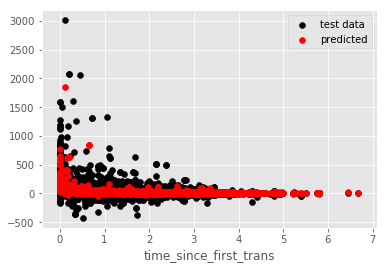

In [189]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
#from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
user_cols = [col for col in list(df.columns) if col.startswith('user_')]
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 'con_len_trans', 'num_comments', 
                         'time_since_first_trans',# 'con_num_words',
                          'user_n_comments_trans', #'con_n_periods_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                        ] + user_cols)),
                # Polynomialfeatures can help a little bit...
#                ('polynomialfeatures', PolynomialFeatures(degree=2)),
            ])),

            ('words_content', Pipeline([
                ('selector', ItemSelector(key='con')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers)),
                ('best', TruncatedSVD(n_components=40)),
            ])),
            
            ('words_title', Pipeline([
                ('selector', ItemSelector(key='tit')),
                ('tfidf', TfidfVectorizer(max_df=0.7, preprocessor=no_numbers)),
                ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_subtitle', Pipeline([
                ('selector', ItemSelector(key='sub')),
                ('tfidf', TfidfVectorizer(max_df=0.7, preprocessor=no_numbers)),
                ('best', TruncatedSVD(n_components=30)),
            ])),

        ]
    )),    
    #('model', MLPRegressor(max_iter=50, hidden_layer_sizes=(100,)))
    ('model', GradientBoostingRegressor(max_depth=3))
    #('model', SVC(kernel='linear', n_jobs=-1))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
#print(y_pred)
#print(classification_report(y_test, y_pred))

# Residual plot
# time_since_first because it seems to have some influence (see feature importance below)
X_res = X_test['time_since_first_trans']
plt.scatter(X_res, y_test, color='black', label='test data')
plt.scatter(X_res, y_pred, color='red', label='predicted')
plt.xlabel('time_since_first_trans')
plt.legend(); plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'model__hidden_layer_sizes':[(50,), (100,), (200,), (100, 50)]
#        'motdel__alpha': np.logspace(-1, 4, 6),
                 }
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

### Summary so far
The decision tree regressor depends a lot on max_depth parameter: Depending on it, the model over- or underfits. I reached the best R^2 score with max_depth=3, but model underfits.

Neural networks work a bit better: R^2 = 0.39 (old try)  
GBRF same: R^2 = 0.45

The models improve slightly with more data, will try bigger runs.

How to extract more information? How to use user behaviour?

In [181]:
#print(model.named_steps['model'].feature_importances_)
model.named_steps['model'].feature_importances_

array([  1.59476026e-03,   1.25101453e-03,   2.69816581e-02,
         2.10460413e-02,   2.23887874e-01,   1.55156849e-03,
         6.13176078e-04,   3.32373727e-03,   0.00000000e+00,
         0.00000000e+00,   2.52139727e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   4.55980708e-04,
         2.75204668e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.28954734e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,